<a href="https://colab.research.google.com/github/skyshine460/GHG_Direct_Emissions/blob/main/submit_ghg55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 予測モデルを訓練するためのデータセット
train_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/train.csv')

# 予測モデルに推論（予測)させるデータセット
test_df = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/test.csv')

In [3]:
train_df.columns.tolist()

['Unnamed: 0',
 'FacilityName',
 'Latitude',
 'Longitude',
 'LocationAddress',
 'City',
 'State',
 'ZIP',
 'County',
 'FIPScode',
 'PrimaryNAICS',
 'SecondPrimaryNAICS',
 'IndustryType',
 'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs',
 'GHG_Direct_Emissions_10_in_metric_tons',
 'GHG_Direct_Emissions_11_in_metric_tons',
 'GHG_Direct_Emissions_12_in_metric_tons',
 'GHG_Direct_Emissions_13_in_metric_tons',
 'GHG_Direct_Emissions_14_in_metric_tons']

[LightGBM] [Info] Number of positive: 2040, number of negative: 3690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1847
[LightGBM] [Info] Number of data points in the train set: 5730, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356021 -> initscore=-0.592677
[LightGBM] [Info] Start training from score -0.592677
Adversarial Validation AUC: 0.5507
The training and test distributions are similar.


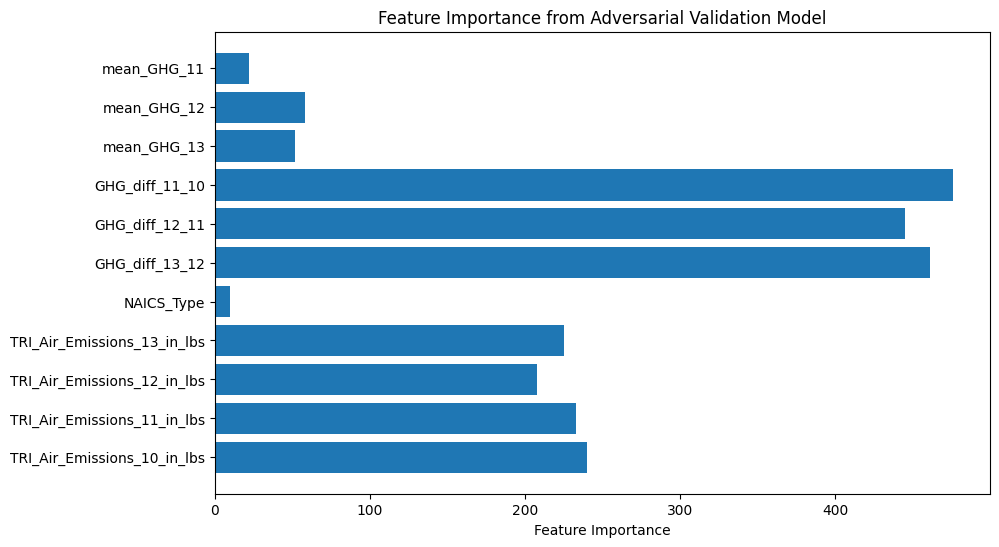

Accuracy: 0.6595


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

# Assuming train_df and test_df are your training and test dataframes




# train_df = train_df.fillna()
# test_df = test_df.fillna()

# Prepare the data by adding a "label" column
train_df['label'] = 0
test_df['label'] = 1

# Concatenate train and test data
combined_df = pd.concat([train_df, test_df], axis=0)

# Convert object columns to category
def convert_object_to_category(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].astype('category')
    return df
combined_df = convert_object_to_category(combined_df)

# Remove columns
combined_df = combined_df.drop(columns=['Unnamed: 0', 'FacilityName', 'LocationAddress', 'ZIP', 'GHG_Direct_Emissions_14_in_metric_tons', 'IndustryType'])

# PrimaryNAICSを文字数ごとに分割
naics_types      = {11: 'Agriculture, Forestry, Fishing and Hunting',
                    21: 'Mining, Quarrying, and Oil and Gas Extraction',
                    22: 'Utilities',
                    23: 'Construction',
                    31: 'Manufacturing',
                    32: 'Manufacturing',
                    33: 'Manufacturing',
                    42: 'Wholesale Trade',
                    44: 'Retail Trade',
                    45: 'Retail Trade',
                    48: 'Transportation and Warehousing',
                    49: 'Transportation and Warehousing',
                    51: 'Information',
                    52: 'Finance and Insurance',
                    53: 'Real Estate and Rental and Leasing',
                    54: 'Professional, Scientific, and Technical Services',
                    55: 'Management of Companies and Enterprises',
                    56: 'Administrative and Support and Waste Management and Remediation Services',
                    61: 'Educational Services',
                    62: 'Health Care and Social Assistance',
                    71: 'Arts, Entertainment, and Recreation',
                    72: 'Accommodation and Food Services',
                    81: 'Other Services (except Public Administration)',
                    92: 'Public Administration'}
combined_df['PrimaryNAICS_1-2'] = combined_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
combined_df['NAICS_Type'] = combined_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# 各年の差から予測
combined_df['GHG_diff_13_12'] = combined_df['GHG_Direct_Emissions_13_in_metric_tons'] - combined_df['GHG_Direct_Emissions_12_in_metric_tons']
combined_df['GHG_diff_12_11'] = combined_df['GHG_Direct_Emissions_12_in_metric_tons'] - combined_df['GHG_Direct_Emissions_11_in_metric_tons']
combined_df['GHG_diff_11_10'] = combined_df['GHG_Direct_Emissions_11_in_metric_tons'] - combined_df['GHG_Direct_Emissions_10_in_metric_tons']

# Calculate the aggregated values
grouped1 = combined_df.groupby('NAICS_Type')['GHG_Direct_Emissions_13_in_metric_tons'].agg(['mean']).rename(columns={'mean': 'mean_GHG_13'})
grouped2 = combined_df.groupby('NAICS_Type')['GHG_Direct_Emissions_12_in_metric_tons'].agg(['mean']).rename(columns={'mean': 'mean_GHG_12'})
grouped3 = combined_df.groupby('NAICS_Type')['GHG_Direct_Emissions_11_in_metric_tons'].agg(['mean']).rename(columns={'mean': 'mean_GHG_11'})

# Merge the aggregated data back into the original dataframe
combined_df = pd.merge(combined_df, grouped1, on='NAICS_Type', how='left')
combined_df = pd.merge(combined_df, grouped2, on='NAICS_Type', how='left')
combined_df = pd.merge(combined_df, grouped3, on='NAICS_Type', how='left')



# Separate features and target
feature = [
  'TRI_Air_Emissions_10_in_lbs',
 'TRI_Air_Emissions_11_in_lbs',
 'TRI_Air_Emissions_12_in_lbs',
 'TRI_Air_Emissions_13_in_lbs', 'NAICS_Type',
 'GHG_diff_13_12', 'GHG_diff_12_11', 'GHG_diff_11_10',
  'mean_GHG_13', 'mean_GHG_12', 'mean_GHG_11'
]
X = combined_df[feature]
y = combined_df['label']



# Split combined data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an adversarial model using LightGBM
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 100,
    'learning_rate': 0.1,
    'random_state': 42
}

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_valid],
    callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)])

# Evaluate the model
y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
auc_score = roc_auc_score(y_valid, y_pred)
print(f'Adversarial Validation AUC: {auc_score:.4f}')

# Interpretation
if auc_score > 0.75:
    print("Warning: The training and test distributions are significantly different.")
elif auc_score < 0.6:
    print("The training and test distributions are similar.")
else:
    print("The training and test distributions have some differences, but not significant.")

# Feature importance
importance = model.feature_importance()
feature_names = X_train.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance)
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Adversarial Validation Model')
plt.show()

from sklearn.metrics import accuracy_score

# Convert predicted probabilities to binary values using a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_valid, y_pred_binary)
print(f'Accuracy: {accuracy:.4f}')

In [5]:
# Adversarialモデルを使って全データのテスト分布に似ているスコアを計算
combined_df['adv_score'] = model.predict(X, num_iteration=model.best_iteration)

# 元のtrainデータのみにフィルタリング
train_only_df = combined_df[combined_df['label'] == 0]

# スコアでソート
train_only_df = train_only_df.sort_values(by='adv_score', ascending=False)

# インデックス番号を取得
train_indices = train_only_df.index

# 8:2にデータを分割（テスト分布に近いデータをバリデーションに）
n_total = len(train_indices)
n_valid = n_total // 5  # 20%をバリデーションとする
valid_indices = train_indices[:n_valid]
train_indices = train_indices[n_valid:]

# インデックスで分けてデータセットを作成
X_train_new = X.loc[train_indices]
y_train_new = y.loc[train_indices]
X_valid_new = X.loc[valid_indices]
y_valid_new = y.loc[valid_indices]

# インデックスを保存してダウンロード可能な状態に
indices_train_df = pd.DataFrame({'train_indices': train_indices})
indices_train_df.to_csv('train_indices.csv', index=False)

indices_valid_df = pd.DataFrame({'valid_indices': valid_indices})
indices_valid_df.to_csv('valid_indices.csv', index=False)



In [6]:
valid_indices

Index([2638, 1005, 2251, 4100,   20, 1172,  544, 2069, 2199, 2189,
       ...
       3691,  637, 4346,  482, 1687, 1470, 3205, 1856, 3384, 3183],
      dtype='int64', length=931)

In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
submit_ghg27 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg27.csv', header=None)
submit_ghg40 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg40.csv', header=None)
submit_ghg38 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg38.csv', header=None)
submit_ghg33 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg33.csv', header=None)
submit_ghg31 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg31.csv', header=None)
submit_ghg42 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg42.csv', header=None)
submit_ghg41 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg41.csv', header=None)
submit_ghg43 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg43.csv', header=None)
submit_ghg46 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg46.csv', header=None)
submit_ghg47_1 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg47-1.csv', header=None)
submit_ghg48 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg48.csv', header=None)
submit_ghg48_1 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg48_1.csv', header=None)
submit_ghg49 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg49.csv', header=None)
submit_ghg50_2 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg50-2.csv', header=None)
submit_ghg51 = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提出データ/submit_ghg51.csv', header=None)

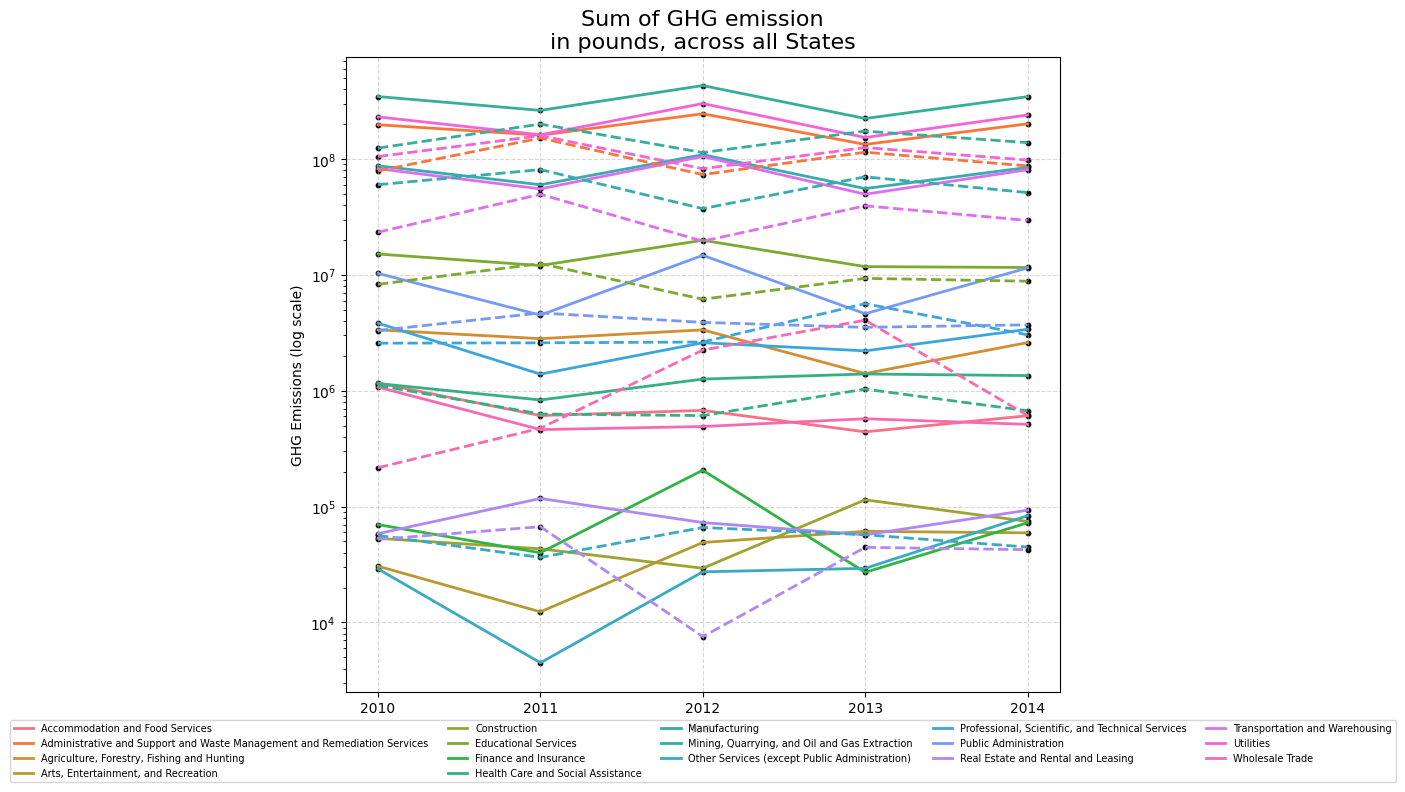

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG.direct.emissions.10': 'sum.GHG.10',
                     'GHG.direct.emissions.11': 'sum.GHG.11',
                     'GHG.direct.emissions.12': 'sum.GHG.12',
                     'GHG.direct.emissions.13': 'sum.GHG.13',
                     'GHG.direct.emissions.14': 'sum.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# ベストの予測結果を反映
# submitのインデックスをリセットし、1列目（元インデックス）を削除
test_pred = submit_ghg27.reset_index(drop=True)

# test_predにカラム名を 'pred' として設定
test_pred.columns = ['id','pred']

# test_dfとtest_predを列方向に結合
test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'sum.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'sum.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'sum.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'sum.GHG.13',
                                          'pred': 'sum.GHG.14', })
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


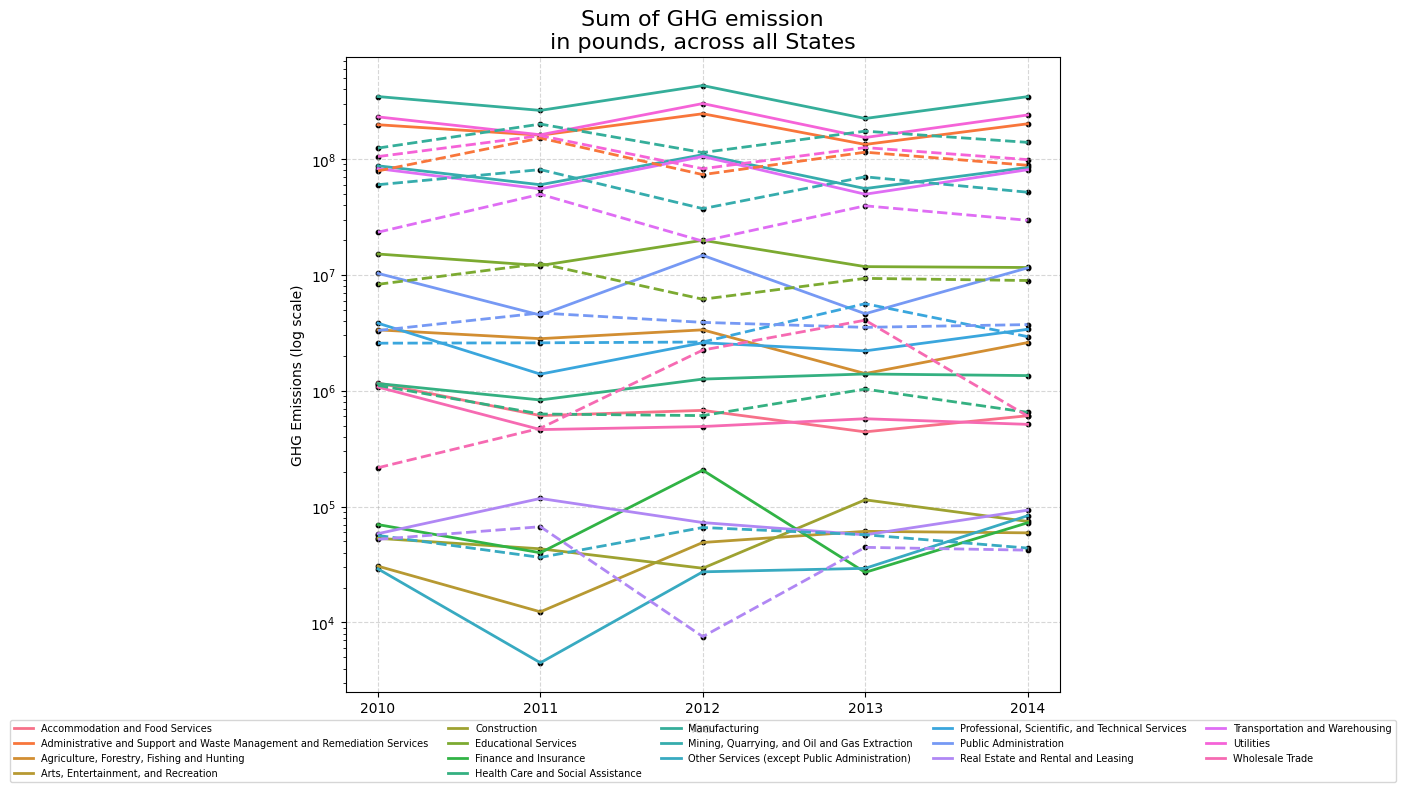

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG.direct.emissions.10': 'sum.GHG.10',
                     'GHG.direct.emissions.11': 'sum.GHG.11',
                     'GHG.direct.emissions.12': 'sum.GHG.12',
                     'GHG.direct.emissions.13': 'sum.GHG.13',
                     'GHG.direct.emissions.14': 'sum.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# ベストの予測結果を反映
# submitのインデックスをリセットし、1列目（元インデックス）を削除
test_pred = submit_ghg40.reset_index(drop=True)

# test_predにカラム名を 'pred' として設定
test_pred.columns = ['id','pred']

# test_dfとtest_predを列方向に結合
test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

# Data preparation for test GHG_sum
test_ghg_sum = (
    test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'sum.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'sum.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'sum.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'sum.GHG.13',
                                          'pred': 'sum.GHG.14', })
)

# Transpose and prepare for plotting
temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
temp_test_ghg.reset_index(inplace=True)
temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Plotting with seaborn and matplotlib
plt.figure(figsize=(12, 8))
unique_industries = pd.concat([temp_ghg_melt['NAICS_Type'], temp_test_ghg_melt['NAICS_Type']]).unique()
colors = sns.color_palette('husl', len(unique_industries))
color_dict = dict(zip(unique_industries, cycle(colors)))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Plot test GHG emissions with dashed lines (no legend)
sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1, linestyle='--', legend=False)
plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color='black', s=10, alpha=1)

plt.yscale('log')
plt.title('Sum of GHG emission\nin pounds, across all States', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


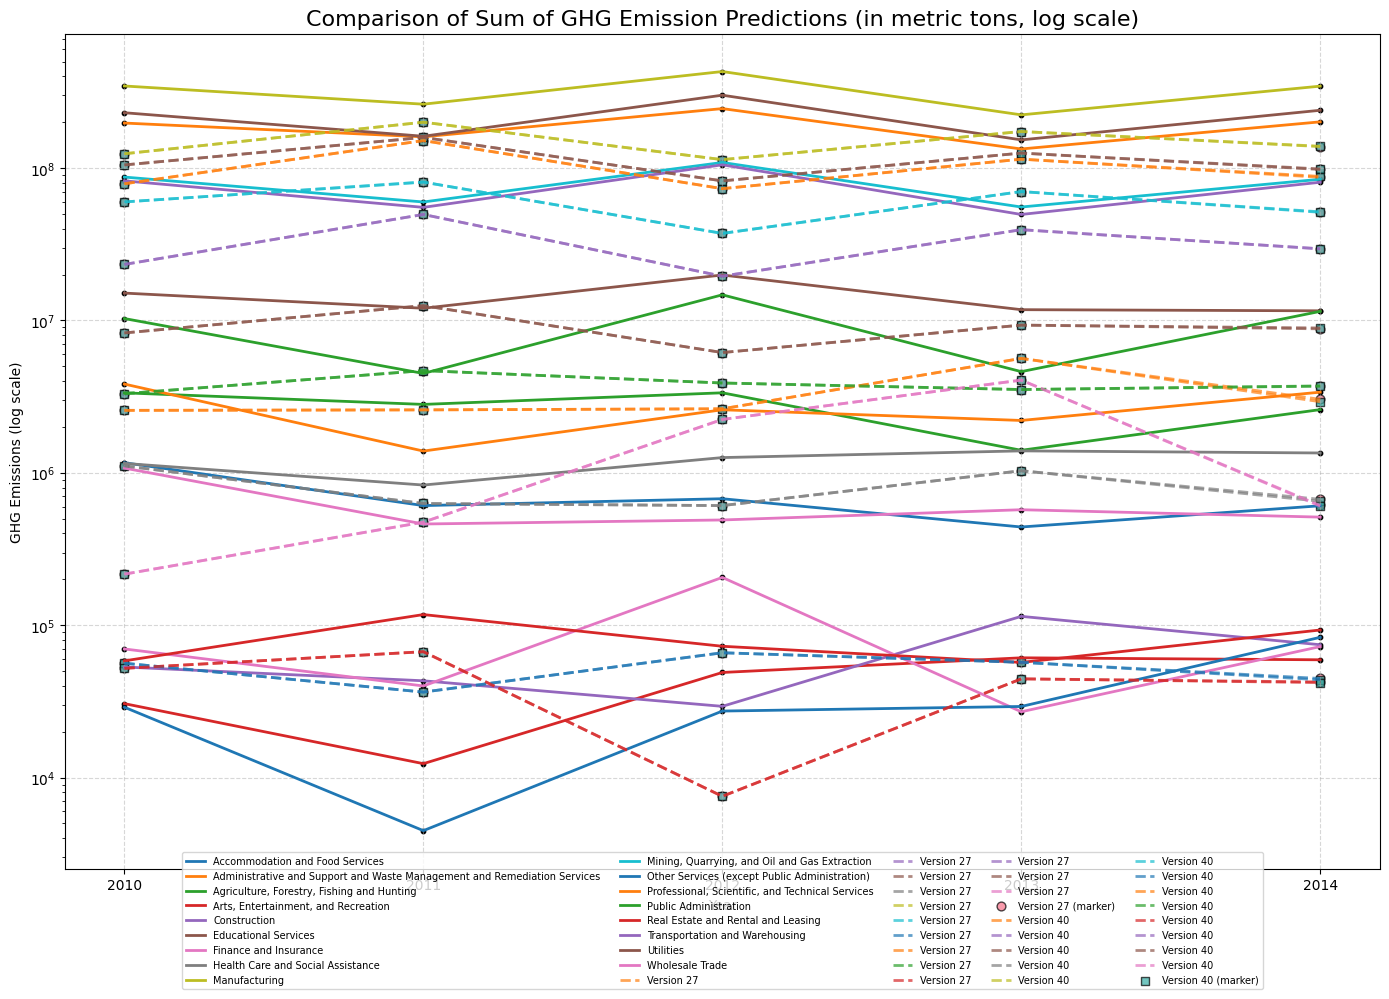

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_sum
ghg_sum = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .sum()
    .rename(columns={'GHG.direct.emissions.10': 'sum.GHG.10',
                     'GHG.direct.emissions.11': 'sum.GHG.11',
                     'GHG.direct.emissions.12': 'sum.GHG.12',
                     'GHG.direct.emissions.13': 'sum.GHG.13',
                     'GHG.direct.emissions.14': 'sum.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_sum.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_sum['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

# Compare two different versions of submit GHG predictions
submit_versions = [submit_ghg27, submit_ghg40]
version_labels = ['Version 27', 'Version 40']
colors = sns.color_palette('husl', len(version_labels))
markers = ['o', 's']

plt.figure(figsize=(14, 10))
unique_industries = temp_ghg_melt['NAICS_Type'].unique()
color_dict = dict(zip(unique_industries, cycle(sns.color_palette('tab10'))))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Iterate over submit versions and plot each one
for submit_data, version_label, color, marker in zip(submit_versions, version_labels, colors, markers):
    # Reset index and add predictions
    test_pred = submit_data.reset_index(drop=True)
    test_pred.columns = ['id', 'pred']
    test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

    # Data preparation for test GHG_sum
    test_ghg_sum = (
        test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
                      'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
        .dropna()
        .groupby('NAICS_Type', as_index=False)
        .sum()
        .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'sum.GHG.10',
                         'GHG_Direct_Emissions_11_in_metric_tons': 'sum.GHG.11',
                         'GHG_Direct_Emissions_12_in_metric_tons': 'sum.GHG.12',
                         'GHG_Direct_Emissions_13_in_metric_tons': 'sum.GHG.13',
                         'pred': 'sum.GHG.14'})
    )

    # Transpose and prepare for plotting
    temp_test_ghg = test_ghg_sum.drop(columns='NAICS_Type').transpose()
    temp_test_ghg.columns = test_ghg_sum['NAICS_Type']
    temp_test_ghg.reset_index(inplace=True)
    temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
    temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

    temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

    # Plot test GHG emissions with dashed lines and different markers
    sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=0.7, linestyle='--', legend=False, label=version_label)
    plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color=color, s=40, alpha=0.7, edgecolors='k', marker=marker, label=f'{version_label} (marker)')

plt.yscale('log')
plt.title('Comparison of Sum of GHG Emission Predictions (in metric tons, log scale)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


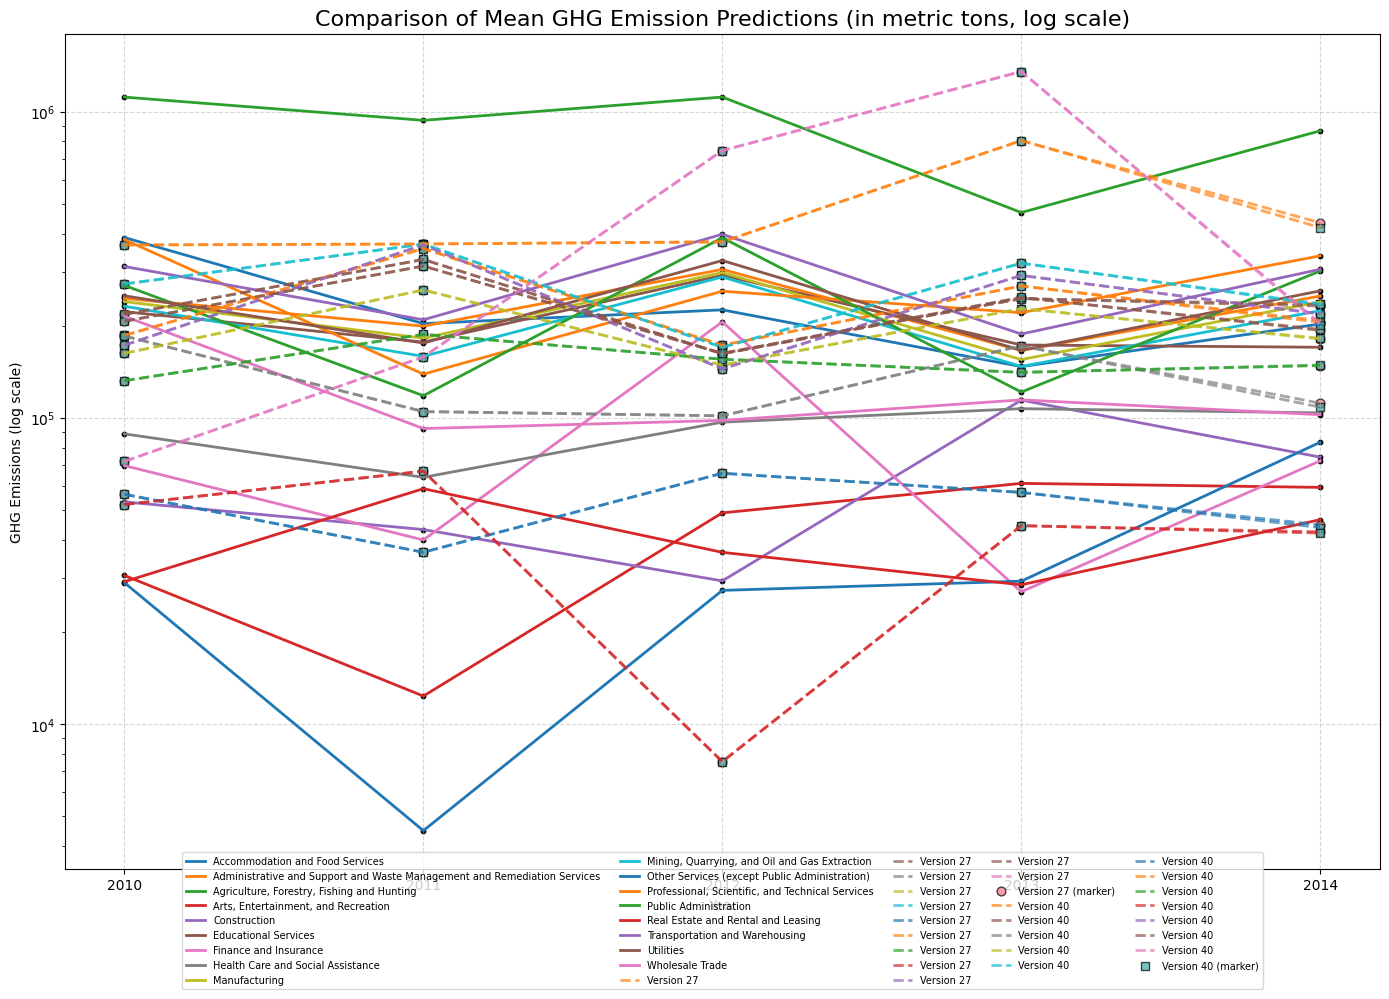

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Compare two different versions of submit GHG predictions
submit_versions = [submit_ghg27, submit_ghg40]
version_labels = ['Version 27', 'Version 40']
colors = sns.color_palette('husl', len(version_labels))
markers = ['o', 's']

plt.figure(figsize=(14, 10))
unique_industries = temp_ghg_melt['primary.industry'].unique()
color_dict = dict(zip(unique_industries, cycle(sns.color_palette('tab10'))))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Iterate over submit versions and plot each one
for submit_data, version_label, color, marker in zip(submit_versions, version_labels, colors, markers):
    # Reset index and add predictions
    test_pred = submit_data.reset_index(drop=True)
    test_pred.columns = ['id', 'pred']
    test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

    # Data preparation for test GHG_mean
    test_ghg_mean = (
        test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
                      'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
        .dropna()
        .groupby('NAICS_Type', as_index=False)
        .mean()
        .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                         'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                         'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                         'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                         'pred': 'mean.GHG.14'})
    )

    # Transpose and prepare for plotting
    temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
    temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
    temp_test_ghg.reset_index(inplace=True)
    temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
    temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

    temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

    # Plot test GHG emissions with dashed lines and different markers
    sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=0.7, linestyle='--', legend=False, label=version_label)
    plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color=color, s=40, alpha=0.7, edgecolors='k', marker=marker, label=f'{version_label} (marker)')

plt.yscale('log')
plt.title('Comparison of Mean GHG Emission Predictions (in metric tons, log scale)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


Version 27 2014 values:
 NAICS_Type  year  \
4           2014   

NAICS_Type  Administrative and Support and Waste Management and Remediation Services  \
4                                               205163.728785                          

NAICS_Type  Construction  Educational Services  \
4                    NaN         231852.634875   

NAICS_Type  Health Care and Social Assistance  Manufacturing  \
4                               111723.556255  181112.271645   

NAICS_Type  Mining, Quarrying, and Oil and Gas Extraction  \
4                                           233996.138397   

NAICS_Type  Other Services (except Public Administration)  \
4                                            44721.049065   

NAICS_Type  Professional, Scientific, and Technical Services  \
4                                              433972.771745   

NAICS_Type  Public Administration  Real Estate and Rental and Leasing  \
4                   148145.507398                        42450.354122   

NAICS

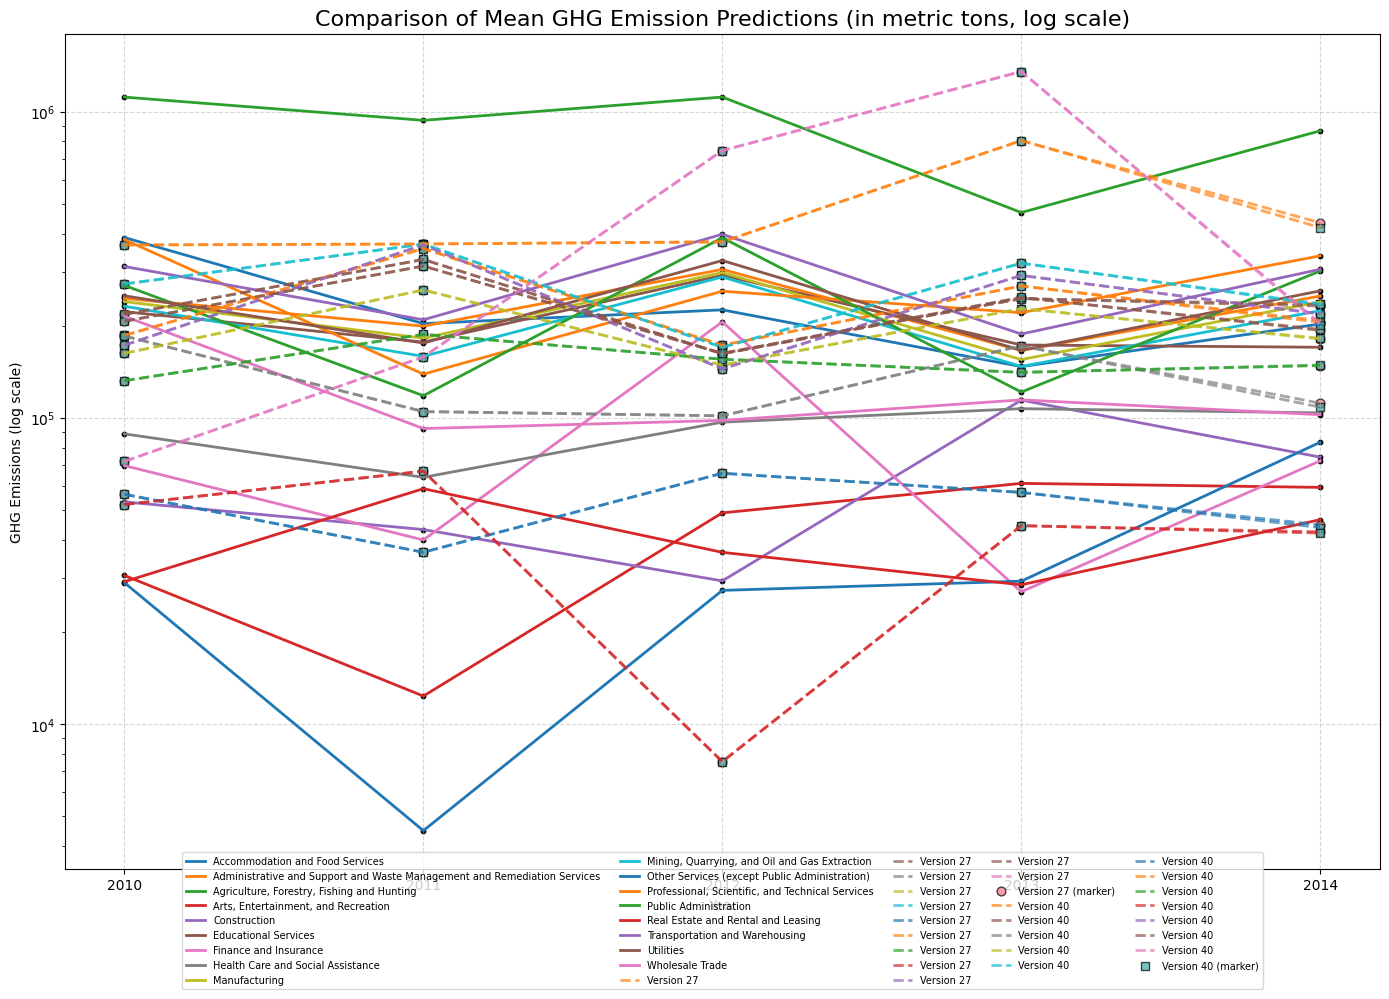

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Compare two different versions of submit GHG predictions
submit_versions = [submit_ghg27, submit_ghg40]
version_labels = ['Version 27', 'Version 40']
colors = sns.color_palette('husl', len(version_labels))
markers = ['o', 's']

plt.figure(figsize=(14, 10))
unique_industries = temp_ghg_melt['primary.industry'].unique()
color_dict = dict(zip(unique_industries, cycle(sns.color_palette('tab10'))))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Iterate over submit versions and plot each one
for submit_data, version_label, color, marker in zip(submit_versions, version_labels, colors, markers):
    # Reset index and add predictions
    test_pred = submit_data.reset_index(drop=True)
    test_pred.columns = ['id', 'pred']
    test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

    # Data preparation for test GHG_mean
    test_ghg_mean = (
        test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
                      'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
        .dropna()
        .groupby('NAICS_Type', as_index=False)
        .mean()
        .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                         'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                         'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                         'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                         'pred': 'mean.GHG.14'})
    )

    # Transpose and prepare for plotting
    temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
    temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
    temp_test_ghg.reset_index(inplace=True)
    temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
    temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

    temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

    # Plot test GHG emissions with dashed lines and different markers
    sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=0.7, linestyle='--', legend=False, label=version_label)
    plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color=color, s=40, alpha=0.7, edgecolors='k', marker=marker, label=f'{version_label} (marker)')

    # Output the value for year 2014 for each version
    values_2014 = temp_test_ghg[temp_test_ghg['year'] == 2014]
    print(f"{version_label} 2014 values:\n", values_2014)

plt.yscale('log')
plt.title('Comparison of Mean GHG Emission Predictions (in metric tons, log scale)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


Version 27 2014 values:
 NAICS_Type  year  \
4           2014   

NAICS_Type  Administrative and Support and Waste Management and Remediation Services  \
4                                               205163.728785                          

NAICS_Type  Construction  Educational Services  \
4                    NaN         231852.634875   

NAICS_Type  Health Care and Social Assistance  Manufacturing  \
4                               111723.556255  181112.271645   

NAICS_Type  Mining, Quarrying, and Oil and Gas Extraction  \
4                                           233996.138397   

NAICS_Type  Other Services (except Public Administration)  \
4                                            44721.049065   

NAICS_Type  Professional, Scientific, and Technical Services  \
4                                              433972.771745   

NAICS_Type  Public Administration  Real Estate and Rental and Leasing  \
4                   148145.507398                        42450.354122   

NAICS

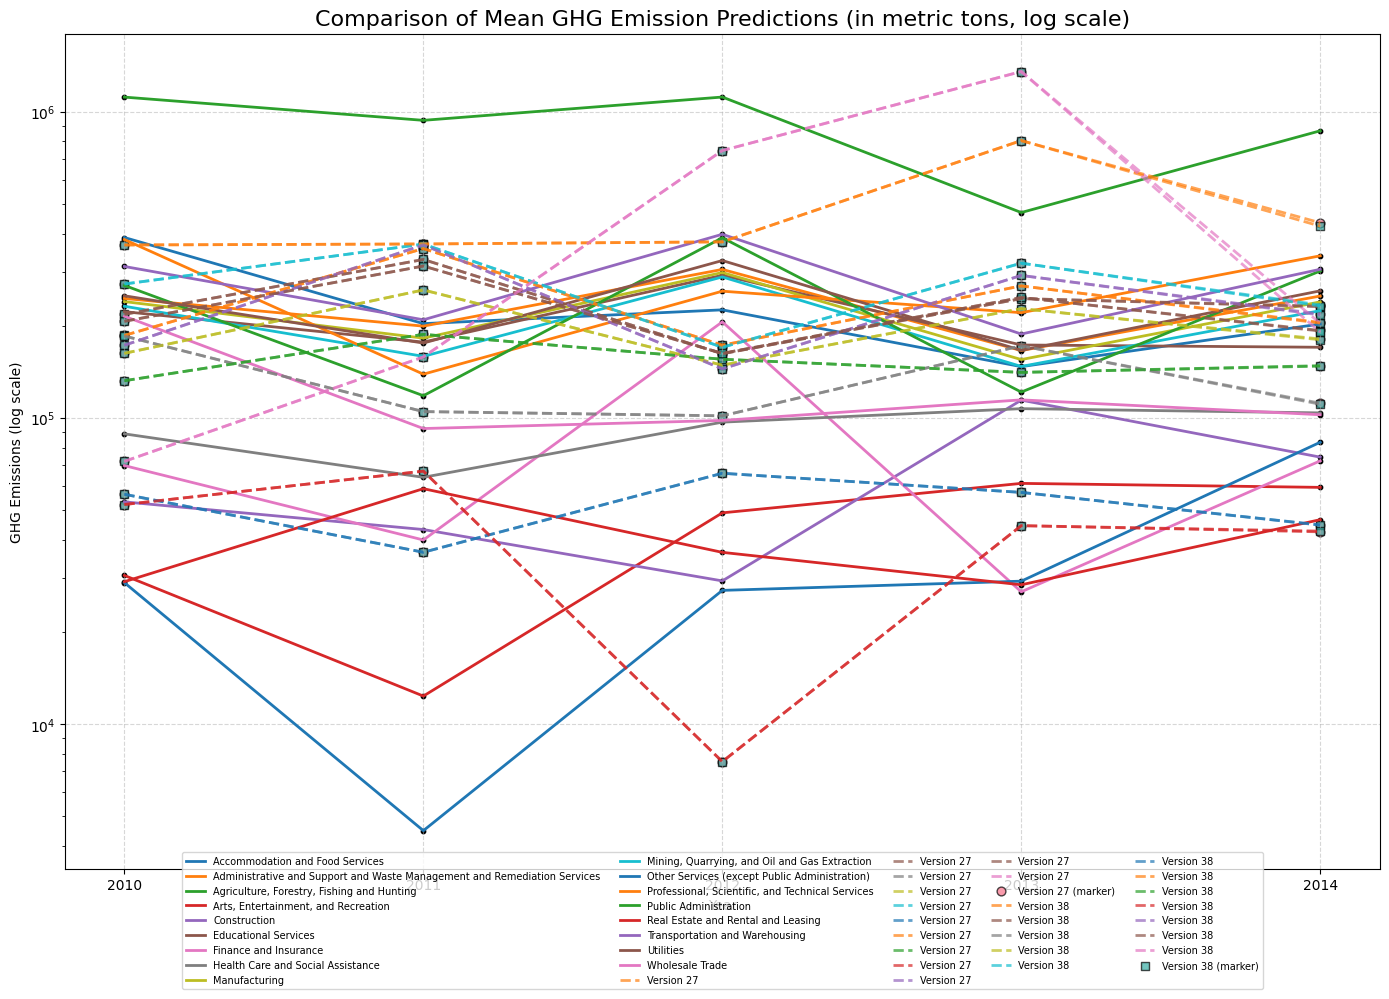

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Compare two different versions of submit GHG predictions
submit_versions = [submit_ghg27, submit_ghg38]
version_labels = ['Version 27', 'Version 38']
colors = sns.color_palette('husl', len(version_labels))
markers = ['o', 's']

plt.figure(figsize=(14, 10))
unique_industries = temp_ghg_melt['primary.industry'].unique()
color_dict = dict(zip(unique_industries, cycle(sns.color_palette('tab10'))))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Iterate over submit versions and plot each one
for submit_data, version_label, color, marker in zip(submit_versions, version_labels, colors, markers):
    # Reset index and add predictions
    test_pred = submit_data.reset_index(drop=True)
    test_pred.columns = ['id', 'pred']
    test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

    # Data preparation for test GHG_mean
    test_ghg_mean = (
        test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
                      'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
        .dropna()
        .groupby('NAICS_Type', as_index=False)
        .mean()
        .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                         'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                         'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                         'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                         'pred': 'mean.GHG.14'})
    )

    # Transpose and prepare for plotting
    temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
    temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
    temp_test_ghg.reset_index(inplace=True)
    temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
    temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

    temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

    # Plot test GHG emissions with dashed lines and different markers
    sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=0.7, linestyle='--', legend=False, label=version_label)
    plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color=color, s=40, alpha=0.7, edgecolors='k', marker=marker, label=f'{version_label} (marker)')

    # Output the value for year 2014 for each version
    values_2014 = temp_test_ghg[temp_test_ghg['year'] == 2014]
    print(f"{version_label} 2014 values:\n", values_2014)

plt.yscale('log')
plt.title('Comparison of Mean GHG Emission Predictions (in metric tons, log scale)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


Version 27 2014 values:
 NAICS_Type  year  \
4           2014   

NAICS_Type  Administrative and Support and Waste Management and Remediation Services  \
4                                               205163.728785                          

NAICS_Type  Construction  Educational Services  \
4                    NaN         231852.634875   

NAICS_Type  Health Care and Social Assistance  Manufacturing  \
4                               111723.556255  181112.271645   

NAICS_Type  Mining, Quarrying, and Oil and Gas Extraction  \
4                                           233996.138397   

NAICS_Type  Other Services (except Public Administration)  \
4                                            44721.049065   

NAICS_Type  Professional, Scientific, and Technical Services  \
4                                              433972.771745   

NAICS_Type  Public Administration  Real Estate and Rental and Leasing  \
4                   148145.507398                        42450.354122   

NAICS

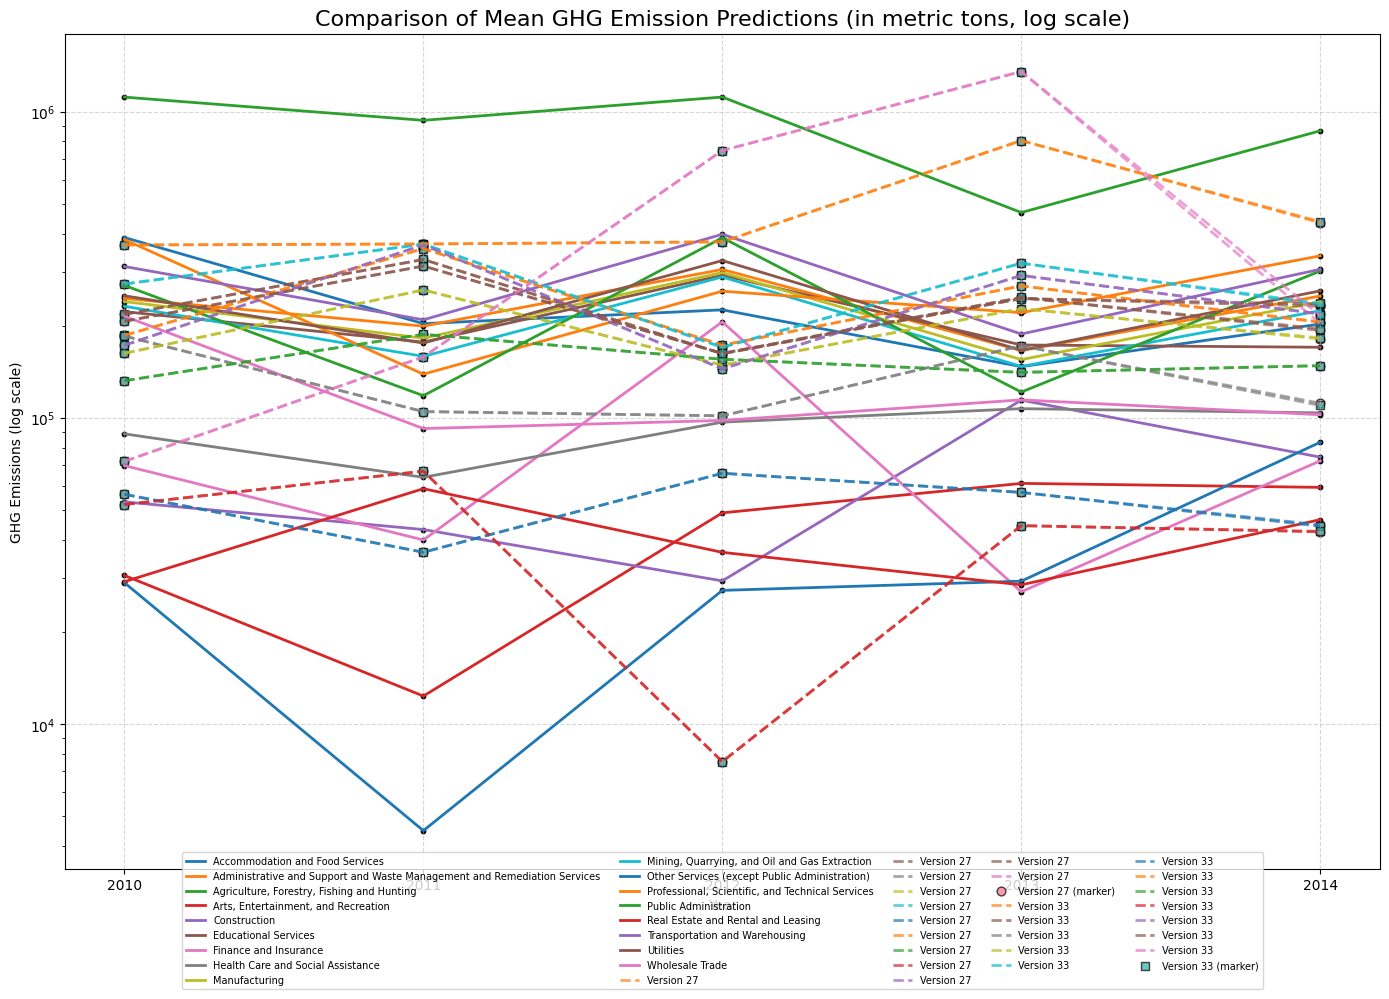

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Compare two different versions of submit GHG predictions
submit_versions = [submit_ghg27, submit_ghg33]
version_labels = ['Version 27', 'Version 33']
colors = sns.color_palette('husl', len(version_labels))
markers = ['o', 's']

plt.figure(figsize=(14, 10))
unique_industries = temp_ghg_melt['primary.industry'].unique()
color_dict = dict(zip(unique_industries, cycle(sns.color_palette('tab10'))))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Iterate over submit versions and plot each one
for submit_data, version_label, color, marker in zip(submit_versions, version_labels, colors, markers):
    # Reset index and add predictions
    test_pred = submit_data.reset_index(drop=True)
    test_pred.columns = ['id', 'pred']
    test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

    # Data preparation for test GHG_mean
    test_ghg_mean = (
        test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
                      'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
        .dropna()
        .groupby('NAICS_Type', as_index=False)
        .mean()
        .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                         'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                         'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                         'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                         'pred': 'mean.GHG.14'})
    )

    # Transpose and prepare for plotting
    temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
    temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
    temp_test_ghg.reset_index(inplace=True)
    temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
    temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

    temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

    # Plot test GHG emissions with dashed lines and different markers
    sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=0.7, linestyle='--', legend=False, label=version_label)
    plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color=color, s=40, alpha=0.7, edgecolors='k', marker=marker, label=f'{version_label} (marker)')

    # Output the value for year 2014 for each version
    values_2014 = temp_test_ghg[temp_test_ghg['year'] == 2014]
    print(f"{version_label} 2014 values:\n", values_2014)

plt.yscale('log')
plt.title('Comparison of Mean GHG Emission Predictions (in metric tons, log scale)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


Version 27 2014 values:
 NAICS_Type  year  \
4           2014   

NAICS_Type  Administrative and Support and Waste Management and Remediation Services  \
4                                               205163.728785                          

NAICS_Type  Construction  Educational Services  \
4                    NaN         231852.634875   

NAICS_Type  Health Care and Social Assistance  Manufacturing  \
4                               111723.556255  181112.271645   

NAICS_Type  Mining, Quarrying, and Oil and Gas Extraction  \
4                                           233996.138397   

NAICS_Type  Other Services (except Public Administration)  \
4                                            44721.049065   

NAICS_Type  Professional, Scientific, and Technical Services  \
4                                              433972.771745   

NAICS_Type  Public Administration  Real Estate and Rental and Leasing  \
4                   148145.507398                        42450.354122   

NAICS

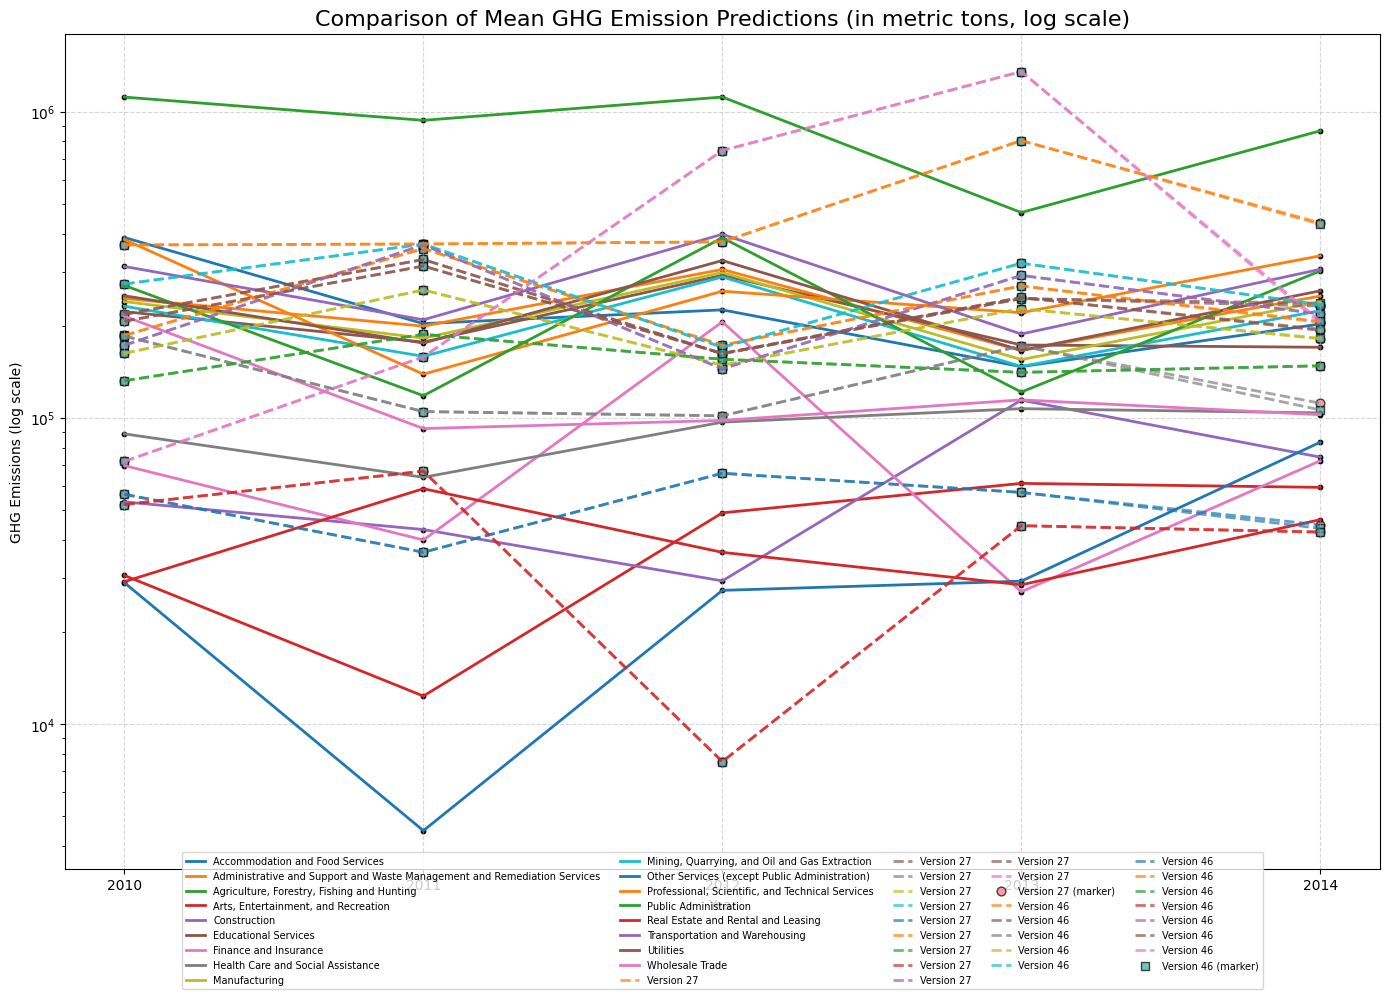

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Compare two different versions of submit GHG predictions
submit_versions = [submit_ghg27, submit_ghg31]
version_labels = ['Version 27', 'Version 46']
colors = sns.color_palette('husl', len(version_labels))
markers = ['o', 's']

plt.figure(figsize=(14, 10))
unique_industries = temp_ghg_melt['primary.industry'].unique()
color_dict = dict(zip(unique_industries, cycle(sns.color_palette('tab10'))))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Iterate over submit versions and plot each one
for submit_data, version_label, color, marker in zip(submit_versions, version_labels, colors, markers):
    # Reset index and add predictions
    test_pred = submit_data.reset_index(drop=True)
    test_pred.columns = ['id', 'pred']
    test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

    # Data preparation for test GHG_mean
    test_ghg_mean = (
        test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
                      'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
        .dropna()
        .groupby('NAICS_Type', as_index=False)
        .mean()
        .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                         'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                         'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                         'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                         'pred': 'mean.GHG.14'})
    )

    # Transpose and prepare for plotting
    temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
    temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
    temp_test_ghg.reset_index(inplace=True)
    temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
    temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

    temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

    # Plot test GHG emissions with dashed lines and different markers
    sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=0.7, linestyle='--', legend=False, label=version_label)
    plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color=color, s=40, alpha=0.7, edgecolors='k', marker=marker, label=f'{version_label} (marker)')

    # Output the value for year 2014 for each version
    values_2014 = temp_test_ghg[temp_test_ghg['year'] == 2014]
    print(f"{version_label} 2014 values:\n", values_2014)

plt.yscale('log')
plt.title('Comparison of Mean GHG Emission Predictions (in metric tons, log scale)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


Version 49 2014 values:
 NAICS_Type  year  \
4           2014   

NAICS_Type  Administrative and Support and Waste Management and Remediation Services  \
4                                               206864.819645                          

NAICS_Type  Construction  Educational Services  \
4                    NaN          233653.42192   

NAICS_Type  Health Care and Social Assistance  Manufacturing  \
4                                 108985.3476  181281.881777   

NAICS_Type  Mining, Quarrying, and Oil and Gas Extraction  \
4                                           235099.841597   

NAICS_Type  Other Services (except Public Administration)  \
4                                            44094.981371   

NAICS_Type  Professional, Scientific, and Technical Services  \
4                                              431494.220097   

NAICS_Type  Public Administration  Real Estate and Rental and Leasing  \
4                   148506.535562                        42611.910029   

NAICS

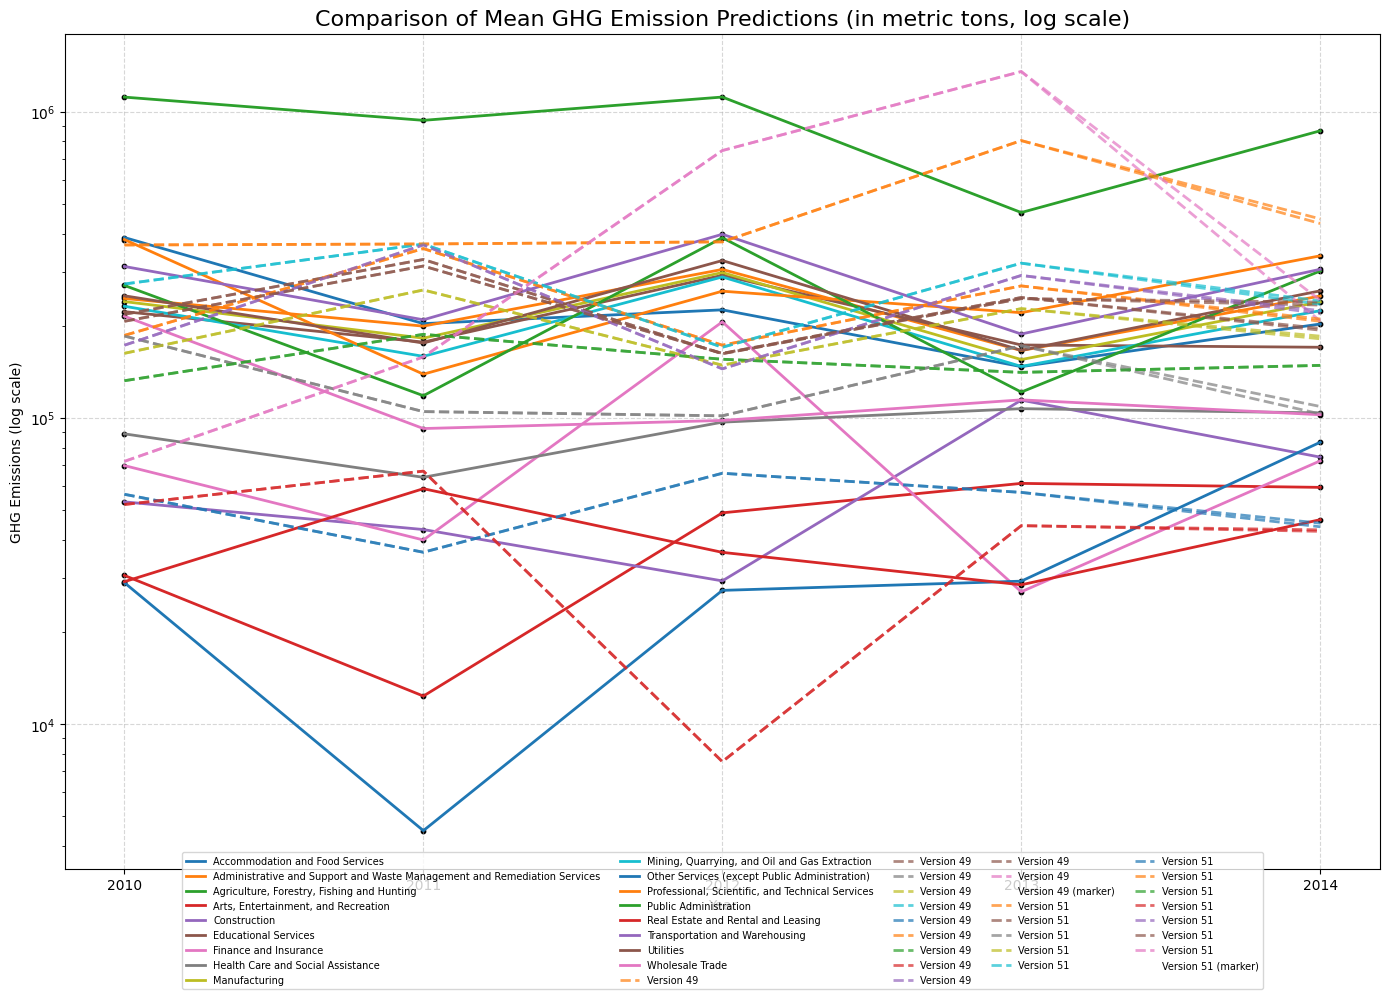

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# PrimaryNAICSを文字数ごとに分割
train_df['PrimaryNAICS_1-2'] = train_df['PrimaryNAICS'].astype(str).str[:2].astype(int)
test_df['PrimaryNAICS_1-2'] = test_df['PrimaryNAICS'].astype(str).str[:2].astype(int)

# PrimaryNAICSを分類してカテゴリ変数へ変換
train_df['NAICS_Type'] = train_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')
test_df['NAICS_Type'] = test_df['PrimaryNAICS_1-2'].map(naics_types).astype('category')

# Data preparation for GHG_mean
ghg_mean = (
    train_df[['NAICS_Type', 'GHG_Direct_Emissions_14_in_metric_tons', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
             'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons']]
    .dropna()
    .groupby('NAICS_Type', as_index=False)
    .mean()
    .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                     'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                     'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                     'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                     'GHG_Direct_Emissions_14_in_metric_tons': 'mean.GHG.14'})
)

# Transpose and prepare for plotting
temp_ghg = ghg_mean.drop(columns='NAICS_Type').transpose()
temp_ghg.columns = ghg_mean['NAICS_Type']
temp_ghg.reset_index(inplace=True)
temp_ghg.rename(columns={'index': 'year'}, inplace=True)
temp_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

temp_ghg_melt = pd.melt(temp_ghg, id_vars=['year'], var_name='primary.industry', value_name='value')

# Compare two different versions of submit GHG predictions
submit_versions = [submit_ghg49, submit_ghg51]
version_labels = ['Version 49', 'Version 51']
colors = sns.color_palette('husl', len(version_labels))
markers = ['', '']

plt.figure(figsize=(14, 10))
unique_industries = temp_ghg_melt['primary.industry'].unique()
color_dict = dict(zip(unique_industries, cycle(sns.color_palette('tab10'))))

# Plot original GHG emissions
sns.lineplot(data=temp_ghg_melt, x='year', y='value', hue='primary.industry', palette=color_dict, linewidth=2, alpha=1)
plt.scatter(temp_ghg_melt['year'], temp_ghg_melt['value'], color='black', s=10, alpha=1)

# Iterate over submit versions and plot each one
for submit_data, version_label, color, marker in zip(submit_versions, version_labels, colors, markers):
    # Reset index and add predictions
    test_pred = submit_data.reset_index(drop=True)
    test_pred.columns = ['id', 'pred']
    test_df_pred = pd.concat([test_df.reset_index(drop=True), test_pred], axis=1)

    # Data preparation for test GHG_mean
    test_ghg_mean = (
        test_df_pred[['NAICS_Type', 'GHG_Direct_Emissions_13_in_metric_tons', 'GHG_Direct_Emissions_12_in_metric_tons',
                      'GHG_Direct_Emissions_11_in_metric_tons', 'GHG_Direct_Emissions_10_in_metric_tons', 'pred']]
        .dropna()
        .groupby('NAICS_Type', as_index=False)
        .mean()
        .rename(columns={'GHG_Direct_Emissions_10_in_metric_tons': 'mean.GHG.10',
                         'GHG_Direct_Emissions_11_in_metric_tons': 'mean.GHG.11',
                         'GHG_Direct_Emissions_12_in_metric_tons': 'mean.GHG.12',
                         'GHG_Direct_Emissions_13_in_metric_tons': 'mean.GHG.13',
                         'pred': 'mean.GHG.14'})
    )

    # Transpose and prepare for plotting
    temp_test_ghg = test_ghg_mean.drop(columns='NAICS_Type').transpose()
    temp_test_ghg.columns = test_ghg_mean['NAICS_Type']
    temp_test_ghg.reset_index(inplace=True)
    temp_test_ghg.rename(columns={'index': 'year'}, inplace=True)
    temp_test_ghg['year'] = [2010, 2011, 2012, 2013, 2014]

    temp_test_ghg_melt = pd.melt(temp_test_ghg, id_vars=['year'], var_name='NAICS_Type', value_name='value')

    # Plot test GHG emissions with dashed lines and different markers
    sns.lineplot(data=temp_test_ghg_melt, x='year', y='value', hue='NAICS_Type', palette=color_dict, linewidth=2, alpha=0.7, linestyle='--', legend=False, label=version_label)
    plt.scatter(temp_test_ghg_melt['year'], temp_test_ghg_melt['value'], color=color, s=40, alpha=0.7, edgecolors='k', marker=marker, label=f'{version_label} (marker)')

    # Output the value for year 2014 for each version
    values_2014 = temp_test_ghg[temp_test_ghg['year'] == 2014]
    print(f"{version_label} 2014 values:\n", values_2014)

plt.yscale('log')
plt.title('Comparison of Mean GHG Emission Predictions (in metric tons, log scale)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('GHG Emissions (log scale)')
plt.xticks(temp_ghg['year'])
plt.legend(title='', loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=5, fontsize=7)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


In [18]:
test_prediction = submit_ghg51.iloc[:, 1] + submit_ghg27.iloc[:, 1] + submit_ghg46.iloc[:, 1]
test_prediction = test_prediction / 3
test_prediction = test_prediction.reset_index(drop=True)
submit = pd.read_csv('/content/drive/MyDrive/GHGの排出量の予測にチャレンジしよう！（SMBC Group GREEN×DATA Challenge 2024）/提供データ/sample_submission.csv', header=None)
submit[1] = test_prediction
submit.to_csv('submit_ghg55.csv', header=None, index=False)

# 投稿ファイルの中身を確認
submit.head()

,0,1
0,4655,45547.451372
1,4656,300275.649071
2,4657,41371.129276
3,4658,27591.092573
4,4659,46424.902230
